In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *

## Preliminary setting

In [2]:
# Number of cities
N = 25

# Generating positions of the cities to visit
cities = pd.DataFrame({
    "x" : np.random.uniform(size=N),
    "y" : np.random.uniform(size=N)})
    
cities.tail()

,x,y
20,0.394414,0.529134
21,0.828024,0.016982
22,0.592087,0.226944
23,0.584184,0.694728
24,0.567165,0.729016


In [3]:
# Computing the distance matrix using the L2 distance function and the cities' coordinates
D = D_matrix(L2, cities)

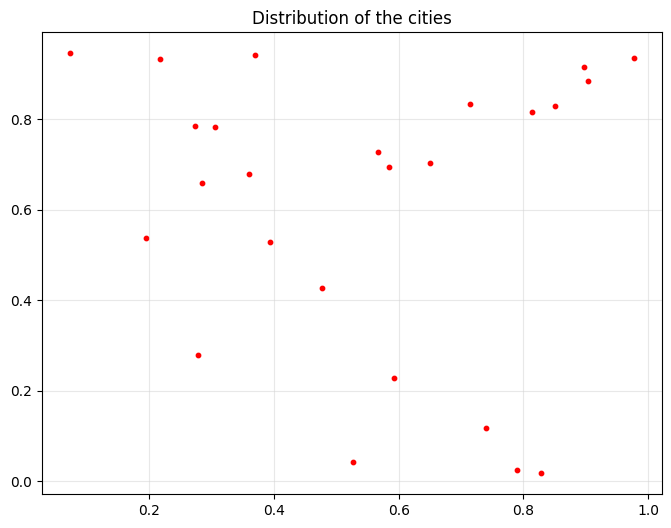

In [4]:
# Visualizing the distribution of the nodes
plt.figure(figsize=(8, 6))
plt.title("Distribution of the cities")
plt.grid(color='lightgray', alpha=0.5)
plt.scatter(cities["x"], cities["y"], s=10, c="r")

## Minimization algorithm

In [5]:
#Model hyperparameters
T0 = 20
T_f = 0.005
alpha = 0.999

#Model training
conf_i, hist, best, tested = SA(D, T0, T_f, alpha)

In [6]:
#Explicit number of interactions performed
it = int(np.ceil(np.log(T_f/T0)/np.log(alpha)))
print("Performed " + str(it) + " interactions")

#Print total distance of the best configuration
print("Total distance of the best configuration: " + str(round(best[-1], 4)))

Performed 8290 interactions
Total distance of the best configuration: 4.6481


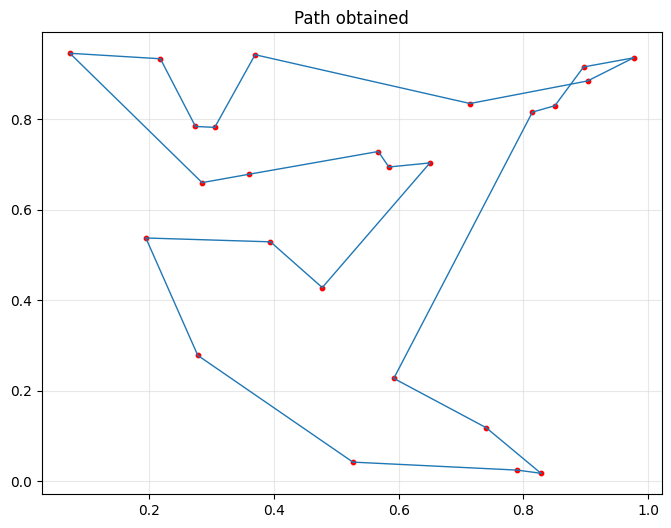

In [7]:
plt.figure(figsize=(8, 6))
plt.title("Path obtained")
plt.grid(color='lightgray', alpha=0.5)

plt.scatter(cities["x"], cities["y"], s=10, c="r")
for i in range(N):
    x = [cities["x"][conf_i[i+1]], cities["x"][conf_i[i]]]
    y = [cities["y"][conf_i[i+1]], cities["y"][conf_i[i]]]
    plt.plot(x, y, lw=1, c="#1f77b4")

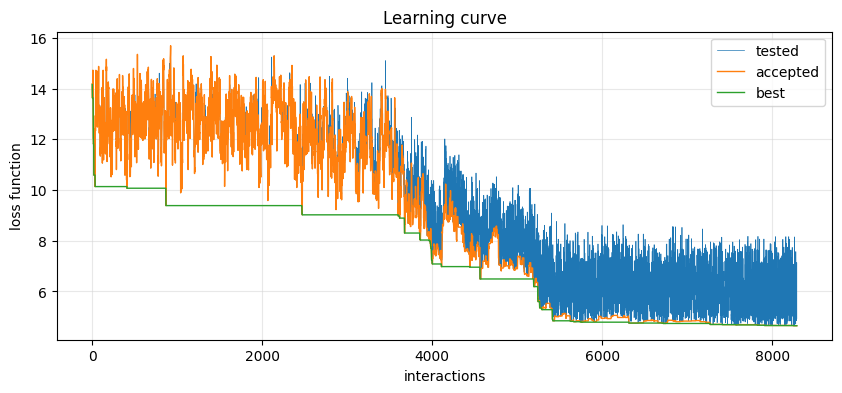

In [8]:
plt.figure(figsize=(10, 4))
plt.title("Learning curve")
plt.grid(color='lightgray', alpha=0.5)
plt.xlabel("interactions")
plt.ylabel("loss function")

x = np.arange(len(hist))
plt.plot(x, tested, lw=0.5, label="tested")
plt.plot(x, hist, lw=1, label="accepted")
plt.plot(x, best, lw=1, label="best")
plt.legend()

## Hyperparameters tuning

In [9]:
#Number of hyperparameters to test in the grid
n_alpha = 11
n_T0 = 12
n_Tf = 15

#Grid of hyperparameters (start and end are made explicit)
grid_alpha = np.linspace(0.1, 0.99, n_alpha)
grid_T0 = np.linspace(1.1, 10, n_T0)
grid_Tf = np.linspace(10**-5, 1, n_Tf)

In [10]:
#Tensor z: contains the "best" value for each point of the 3D grid of the hyperparameters
z = np.zeros((n_T0, n_alpha, n_Tf))
for i in range(n_T0):
    for j in range(n_alpha):
        for k in range(n_Tf):
            z[i][j][k] = SA_light(D, grid_T0[i], grid_Tf[k], grid_alpha[j])[1]

In [11]:
#Tensor s: contains the standard deviation of the "best" values ​​calculated "reps" times
reps = 10

s = np.zeros((n_T0, n_alpha, n_Tf))
for i in range(n_T0):
    for j in range(n_alpha):
        for k in range(n_Tf):
            r = np.array([])
            for r in range(reps):
                r = np.append(r, SA_light(D, grid_T0[i], grid_Tf[k], grid_alpha[j])[1])
            s[i][j][k] = r.std(ddof=1)

In [12]:
#2D matrices for z profiling the third parameter
z1 = np.zeros((n_T0, n_alpha))
for i in range(n_T0):
    for j in range(n_alpha):
        z1[i][j] = np.min(z[i, j, :])
        
z2 = np.zeros((n_T0, n_Tf))
for i in range(n_T0):
    for k in range(n_Tf):
        z2[i][k] = np.min(z[i, :, k])
        
z3 = np.zeros((n_alpha, n_Tf))
for j in range(n_alpha):
    for k in range(n_Tf):
        z3[j][k] = np.min(z[:, j, k])

In [13]:
#2D matrices for s profiling the third parameter
s1 = np.zeros((n_T0, n_alpha))
for i in range(n_T0):
    for j in range(n_alpha):
        s1[i][j] = np.min(s[i, j, :])
        
s2 = np.zeros((n_T0, n_Tf))
for i in range(n_T0):
    for k in range(n_Tf):
        s2[i][k] = np.min(s[i, :, k])
        
s3 = np.zeros((n_alpha, n_Tf))
for j in range(n_alpha):
    for k in range(n_Tf):
        s3[j][k] = np.min(s[:, j, k])

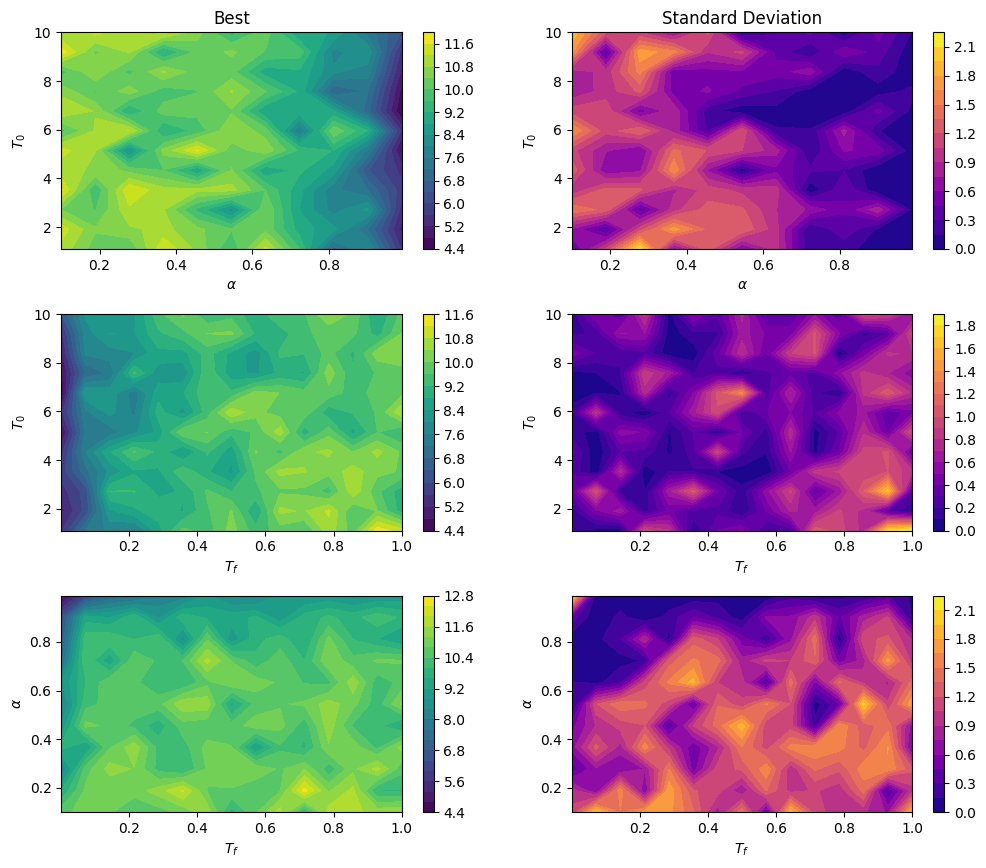

In [14]:
#Contour plot for different 2D matrices
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.9, top=0.9, wspace=0.2,hspace=0.3)

cmap1 = "viridis"
cmap2 = "plasma"

#alpha-T0 comparison
plt.subplot(321)
plt.title("Best")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$T_0$")
plt.contourf(grid_alpha, grid_T0, z1, 20, cmap=cmap1)
plt.colorbar()
plt.subplot(322)
plt.title("Standard Deviation")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$T_0$")
plt.contourf(grid_alpha, grid_T0, s1, 20, cmap=cmap2)
plt.colorbar()

#Tf-T0 comparison
plt.subplot(323)
plt.xlabel(r"$T_f$")
plt.ylabel(r"$T_0$")
plt.contourf(grid_Tf, grid_T0, z2, 20, cmap=cmap1)
plt.colorbar()
plt.subplot(324)
plt.xlabel(r"$T_f$")
plt.ylabel(r"$T_0$")
plt.contourf(grid_Tf, grid_T0, s2, 20, cmap=cmap2)
plt.colorbar()

#Tf-alpha comparison
plt.subplot(325)
plt.xlabel(r"$T_f$")
plt.ylabel(r"$\alpha$")
plt.contourf(grid_Tf, grid_alpha, z3, 20, cmap=cmap1)
plt.colorbar()
plt.subplot(326)
plt.xlabel(r"$T_f$")
plt.ylabel(r"$\alpha$")
plt.contourf(grid_Tf, grid_alpha, s3, 20, cmap=cmap2)
plt.colorbar()

The **role of hyperparameters** could be further explored.
In particular, it is noted that:
* Distance is a hyperparameter: for specific problems it could be convenient to use the distance L1, or again, its definition could artificially create regions of space that one prefers not to cover. In the section _real world_ it will become more evident.
* The cooling function is a hyperparameter: we chose to use the update rule $T^{i+1} = \alpha T^i$ but we might prefer an exponential, logarithmic or quadratic dependence.

## Initial acceptance rate

In [15]:
#Define the grid of the T_0
T_grid = np.linspace(start=0.1, stop=6, num=100)
AR = np.array([])

#Get acceptance rate for all T_0
for T in T_grid:
    AR = np.append(AR, acceptance_rate(D, T, it=1e3))
    
#Note: This result has been found to be robust for "it" modifications

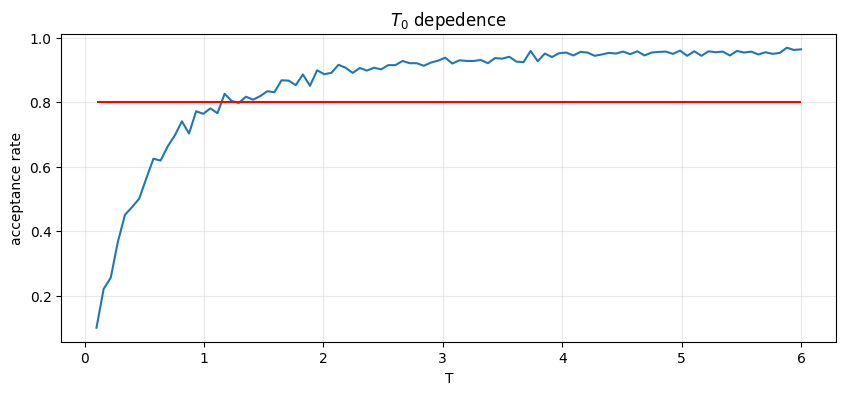

In [16]:
#Visualize dependence of the initial acceptance rate on T_0
plt.figure(figsize=(10, 4))
plt.title(r"$T_0$ depedence")
plt.grid(color='lightgray', alpha=0.5)
plt.xlabel("T")
plt.ylabel("acceptance rate")

plt.plot(T_grid, AR)
plt.hlines(0.8, T_grid[0], T_grid[-1], color="r")

## Visualize training

In [17]:
#Model hyperparameters
T0 = 20
T_f = 0.01
alpha = 0.999

#Model training
history = SA_history(D, T0, T_f, alpha)

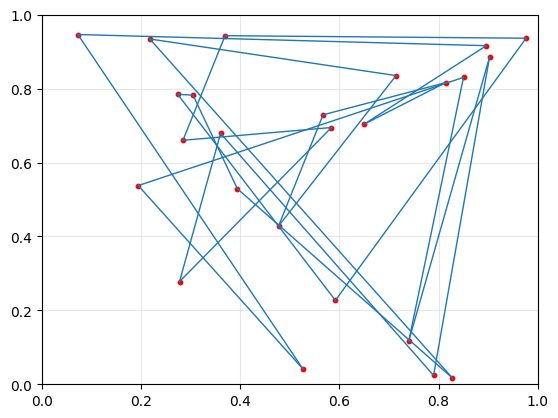

In [18]:
from matplotlib.animation import FuncAnimation, PillowWriter

#Computational cost of animation reduction
anim_history = history[::16]

#Animation
fig, ax = plt.subplots()

def animate(t):
    ax.clear()
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.grid(color='lightgray', alpha=0.5)
    plt.scatter(cities["x"], cities["y"], s=10, c="r")
    
    for i in range(N):
        x = [cities["x"][anim_history[t][i+1]], cities["x"][anim_history[t][i]]]
        y = [cities["y"][anim_history[t][i+1]], cities["y"][anim_history[t][i]]]
        ax.plot(x, y, lw=1, c="#1f77b4")
    
anim = FuncAnimation(fig, animate, len(anim_history))
anim.save("SA.gif", writer=PillowWriter(fps=30))

## Real scenario

In [19]:
import osmnx as ox
import networkx as nx
import folium as folium

In [20]:
#Place choice and route method
place     = "Padua, Italy"
mode      = "walk"           #'drive', 'bike', 'walk'

#Import geographical information as a graph
graph = ox.graph_from_place(place, network_type = mode)

In [21]:
#Category of places
tags = {'amenity': 'bar'}

#Import (geo)Pandas DataFrame
cafe = ox.geometries_from_place(place, tags=tags)
cafe = cafe.reset_index()
cafe = cafe[cafe["element_type"] == "node"]
cafe.tail()

,element_type,osmid,addr:housenumber,addr:street,amenity,name,phone,ref:vatin,wifi,geometry,...,addr:province,addr:state,min_age,payment:cards,payment:contactless,cocktails,cuisine,nodes,contact:website,internet_access:fee
123,node,10156574700,46,Via della Croce Rossa,bar,Anima Underground,NaN,NaN,NaN,POINT (11.91087 45.40955),...,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN
124,node,10159111212,23-25,NaN,bar,Vineria al Calice,NaN,NaN,NaN,POINT (11.91216 45.42666),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,node,10186974101,20,Via Cattaro,bar,Corner bar,NaN,NaN,NaN,POINT (11.87803 45.42663),...,NaN,NaN,NaN,NaN,NaN,NaN,italian,NaN,NaN,NaN
126,node,10718723139,4,Galleria Tito Livio,bar,Fly Bar,NaN,NaN,NaN,POINT (11.87619 45.40428),...,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN
127,node,10762210450,NaN,Via Ognissanti,bar,Bar Clistina,NaN,NaN,NaN,POINT (11.89237 45.40700),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#Randomly choice of "size" places
size = 15
cafe_index = np.random.choice(np.arange(cafe.shape[1]), size=size, replace=False)

In [23]:
#Create DataFrame with latitude and longitude of places
cafe_loc_x = np.array([])
cafe_loc_y = np.array([])

for i in cafe_index:
    cafe_loc_x = np.append(cafe_loc_x, cafe["geometry"][i].x)
    cafe_loc_y = np.append(cafe_loc_y, cafe["geometry"][i].y)
    
cafe_loc = pd.DataFrame({
    "x" : cafe_loc_x, 
    "y" : cafe_loc_y})

cafe_loc.tail()

,x,y
10,11.876038,45.410660
11,11.881766,45.408773
12,11.885791,45.407460
13,11.875857,45.407230
14,11.829873,45.367666


In [24]:
#Define distance through graph
#note: the argument "graph" is implicit and called from outside to use the "D_matrix" function
def dist_graph(cafe_loc, i, j):
    # Find the nearest node in the graph to the position of the places
    source = ox.distance.nearest_nodes(graph, cafe_loc["x"][i], cafe_loc["y"][i], return_dist=False)
    target = ox.distance.nearest_nodes(graph, cafe_loc["x"][j], cafe_loc["y"][j], return_dist=False)

    # Calculate the distance through "dijkstra"
    dist = nx.shortest_path_length(graph, source=source, target=target, weight="length", method='dijkstra')
    return dist

In [25]:
#Calculate the distance matrix
D = D_matrix(dist_graph, cafe_loc)

In [26]:
#simulated annealing in "SA_light" version
conf_i, best = SA_light(D, 1e3, 1, 0.99)

In [27]:
#Save paths (lists of nodes) that connect the nodes in "conf_i"
path = [] # List
paths = [] # List of lists

for i in range(len(conf_i)-1):
    # Find graph node nearest to the location of the cafes
    source = ox.distance.nearest_nodes(graph, cafe_loc["x"][conf_i[i]], cafe_loc["y"][conf_i[i]], return_dist=False)
    target = ox.distance.nearest_nodes(graph, cafe_loc["x"][conf_i[i+1]], cafe_loc["y"][conf_i[i+1]], return_dist=False)

    # Find best path
    shortest = ox.distance.shortest_path(graph, source, target, weight="lenght", cpus=1)
    # Save individual paths separately
    paths.append(shortest)
    # Save aggregate path
    for i in range(len(shortest)-1):
        path.append(shortest[i])


In [28]:
#Visual with folium
shortest_route_map = ox.plot_route_folium(graph, path)
shortest_route_map

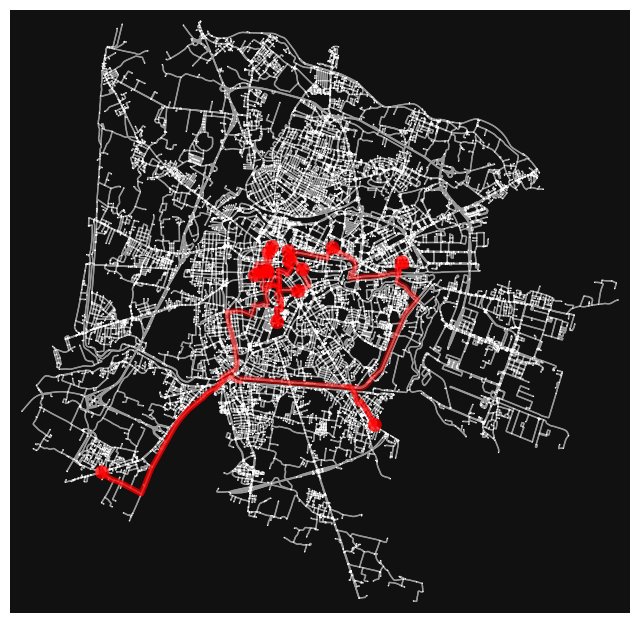

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [29]:
#Visual with graph
ox.plot.plot_graph_routes(graph, paths, node_size=1, orig_dest_size=100)